<a href="https://colab.research.google.com/github/Ismail-Armutcu/Algorithms-for-Interactive-Sytems/blob/ders_kod/MMI513_Week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Week 7: Path finding**

- In this notebook, we will explore several algorithms for finding a path between two points in a graph or map. We will cover Douglas-Peucker algorithm, Seidel's algorithm, and Hertel-Mehlhorn Convex Partitioning.

- We will be leaving the implementation of Algorithm A* as a programming assignment for you to complete. This will allow you to put your knowledge and skills to the test and reinforce your understanding of the concepts we've covered.

## Preamble

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours
import math
import scipy.spatial as spat
from shapely import MultiPoint, Polygon, LineString
from shapely.ops import triangulate

## Douglas-Peucker Algorithm

- Douglas-Peucker is an algorithm used to simplify a polygonal curve, reducing the number of points needed to represent it while still preserving its overall shape. It works by recursively dividing the curve into smaller segments and calculating the distance of each intermediate point to the straight line between the first and last point of the segment. If the distance is greater than a predefined tolerance, then the point furthest from the straight line is added to the final simplified curve. This process is repeated until no points exceed the tolerance, resulting in a polygon with fewer points that still represents the original curve to a desired level of detail.

- `plotpoly` function plots a given polygon
- `bitmaptopoly` function takes an image as input and converts it into a polygon using the Douglas-Peucker algorithm.
- `douglas_peucker` function takes a list of points and a tolerance value and returns a simplified polygon using the Douglas-Peucker algorithm.

- The code also includes helper functions to calculate the distance between a point and a line segment, and a recursive function to simplify the curve.

In [ ]:
def plotpoly(poly, flag=True):
    fig, ax = plt.subplots()
    if flag:
      ax.plot(poly[:, 1], poly[:, 0], 'o-r', linewidth=2)
    else:
      ax.plot(poly[:, 0], poly[:, 1], 'o-r', linewidth=2)
      ax.plot([poly[-1, 0], poly[0, 0]], [poly[-1, 1], poly[0,1]], 'o-r', linewidth=2)
    return ax

def bitmaptopoly(PATH, plotflag=False):
  # Load the image and convert it to grayscale
  image = plt.imread(PATH)
  binaryimage = np.round(image / 255)
  # We are using find_contours from skimage.measure
  contours = find_contours(binaryimage, 0.5)
  # Get the largest
  contour = max(contours, key=len)
  # Convert to list and then to a numpy array
  polygon = contour.tolist()[:-1]
  # If you want to plot it, plot it
  if plotflag:
    poly = np.array(polygon)
    ax = plotpoly(poly)
    ax.imshow(image, cmap='gray')
    plt.show()
  return polygon

def douglas_peucker(points, tolerance):
    # Initialize list of points to keep
    keep = [points[0], points[-1]]

    # Recursive function to simplify the curve
    def simplify_recursive(start, end):
        # Calculate maximum distance from points[start] to points[end]
        max_dist = 0
        max_index = start
        for i in range(start + 1, end):
            dist = distance_to_line(points[start], points[end], points[i])
            if dist > max_dist:
                max_dist = dist
                max_index = i

        # If the maximum distance is greater than the tolerance, add the point and recursively simplify the two segments
        if max_dist > tolerance:
            keep.append(points[max_index])
            simplify_recursive(start, max_index)
            simplify_recursive(max_index, end)

    # Calculate the distance from a point to a line segment
    def distance_to_line(p1, p2, p3):
        x1, y1 = p1
        x2, y2 = p2
        x3, y3 = p3
        px = x2 - x1
        py = y2 - y1
        something = px * px + py * py
        u = ((x3 - x1) * px + (y3 - y1) * py) / float(something)
        if u > 1:
            u = 1
        elif u < 0:
            u = 0
        x = x1 + u * px
        y = y1 + u * py
        dx = x - x3
        dy = y - y3
        dist = math.sqrt(dx * dx + dy * dy)
        return dist

    # Simplify the curve recursively
    simplify_recursive(0, len(points) - 1)

    kpfinal = [] # Input poly in in CCW order but keep is not. We'll put that in CCW order
    for pt in points:
      if pt in keep:
        kpfinal.append(pt)

    # Return the simplified polygon in CCW order
    return kpfinal


## **Testing Code** ✅

- Let us first load a bitmapped version of Ankara map and convert it to a polygon.

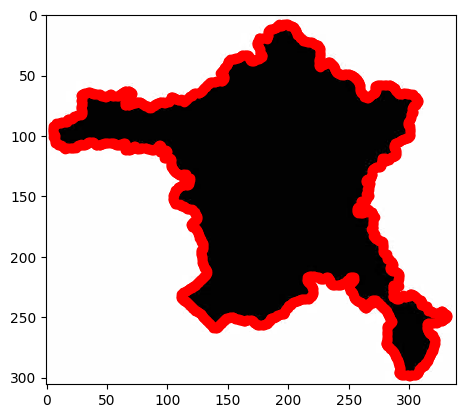

In [ ]:
PATH = './drive/MyDrive/ankarabinary.jpg'
poly = bitmaptopoly(PATH, True)

- Let us now test Douglas-Peucker algorithm to convert our map to a simplified polygon

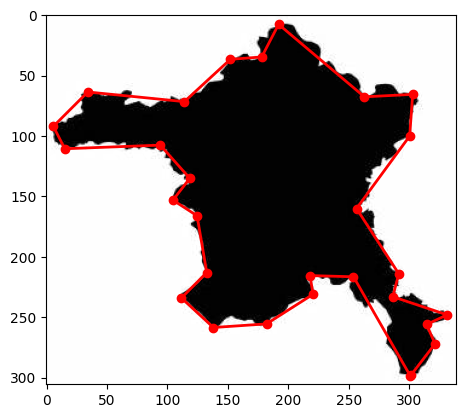

In [ ]:
# Test the function with a sample curve
image = plt.imread(PATH)
tolerance = 1
simplified = douglas_peucker(poly, 10)
simp = np.array(simplified)
ax = plotpoly(simp)
ax.imshow(image, cmap='gray')

## Seidel's algorithm

- Seidel's triangulation algorithm is a method used to triangulate a set of points in a 2D plane. Triangulation is the process of dividing a set of points into triangles such that no two triangles intersect.

- The algorithm starts by sorting the points along the x-axis and then creating a vertical line that divides the points into two sets. The algorithm recursively applies itself to each of the two sets until each set contains only two or three points. Then, the algorithm merges the two sets by finding the upper and lower common tangent lines between them, and removes the points in between. The algorithm continues to recursively apply itself to the left and right halves of the remaining points until the entire set is triangulated.

In [ ]:
def seidel_trig(points):
    def orientation(p1, p2, p3):
        """Compute the orientation of the triplet (p1, p2, p3)
        Returns:
            >0 if the triplet is counter-clockwise
            =0 if the triplet is collinear
            <0 if the triplet is clockwise
        """
        # Define three vectors
        p1p = np.array([p1[0], p1[1], 0.])
        p2p = np.array([p2[0], p2[1], 0.])
        p3p = np.array([p3[0], p3[1], 0.])
        # Define differences
        p12 = p2p - p1p
        p23 = p3p - p2p
        # Take the cross product
        cv = np.cross(p12, p23)
        return cv[2]

    def is_ear(i, n, points):
        p1 = points[(i-1) % n]
        p2 = points[i % n]
        p3 = points[(i+1) % n]
        if orientation(p1, p2, p3) <= 0:
            # The triangle is not counter-clockwise, so it's not an ear
            return False
        for j in range(n):
            if j == i % n or j == (i-1) % n or j == (i+1) % n:
                continue
            p = points[j]
            if (p[0] > min(p1[0], p2[0]) and p[0] < max(p1[0], p2[0]) and
                    p[1] > min(p1[1], p2[1]) and p[1] < max(p1[1], p2[1])):
                # The point is inside the triangle, so it's not an ear
                return False
        return True

    n = len(points)
    triangulation = []
    edges = set()
    edgepoly = set()
    vertices = points

    for ind in range(n-1):
      e = (ind, ind+1)
      edgepoly = edgepoly.union({e})
      edgepoly = edgepoly.union({(n-1,0)})

    while n > 3:
      for i in range(n):
          if is_ear(i, n, points):
              #triangulation.append(((i-1) % n, i % n, (i+1) % n))
              triangulation.append((points[(i-1) % n,:], points[i % n,:], points[(i+1) % n,:]))
              ind1 = np.where((vertices == points[(i-1) % n,:]).all(axis=1))[0][0]
              ind2 = np.where((vertices == points[i % n,:]).all(axis=1))[0][0]
              ind3 = np.where((vertices == points[(i+1) % n,:]).all(axis=1))[0][0]
              # e1 = (ind1, ind2)
              # e2 = (ind2, ind3)
              e = (ind3, ind1)
              edges = edges.union({e})
              points = np.delete(points, i, 0)
              n -= 1
              break

    triangulation.append((points[0], points[1], points[2]))
    ind1 = np.where((vertices == points[0,:]).all(axis=1))[0][0]
    ind2 = np.where((vertices == points[1,:]).all(axis=1))[0][0]
    ind3 = np.where((vertices == points[2,:]).all(axis=1))[0][0]
    # e1 = (ind1, ind2)
    # e2 = (ind2, ind3)
    e = (ind3, ind1)
    edges = edges.union({e})
    return triangulation, edges, vertices, edgepoly

def plottrig(ax, trig, sflag = False):
  trg = []
  ind1, ind2 = 0, 1
  if sflag:
    ind1, ind2 = 1, 0
  for item in trig:
    trg.append([item[ind1], item[ind2]])
  ax.add_patch(plt.Polygon(trg, edgecolor='k'))  # create a polygon patch
  return ax


## **Testing code** ✅

- Let us try it with the Ankara map first

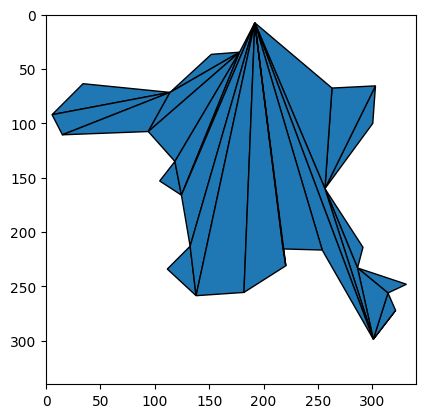

{(1, 28), (20, 11), (21, 10), (23, 10), (24, 10), (6, 4), (15, 13), (10, 28), (10, 26), (26, 10), (2, 28), (10, 6), (8, 6), (20, 18), (13, 11), (6, 28), (25, 10), (16, 13), (10, 27), (9, 6), (4, 28), (17, 13), (4, 2), (20, 10), (23, 21), (17, 11), (18, 11)}


In [ ]:
trigs, edges, vertices, edgepoly = seidel_trig(simp)
fig, ax = plt.subplots()

for trig in trigs:
  ax = plottrig(ax, trig, sflag=True)

ax.set_aspect('equal')
plt.xlim(0, 340)
plt.ylim(0, 340)
ax.invert_yaxis()
plt.show()
print(edges)

- Let us now define a simple room geometry as a polygon and try it on this polygon.

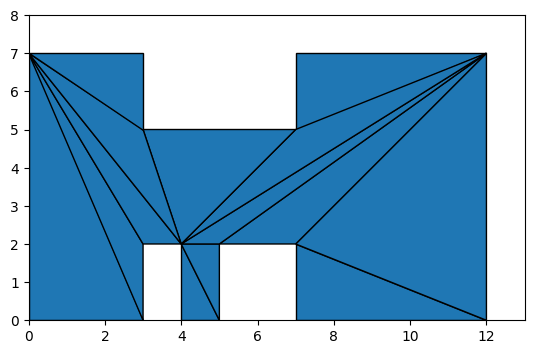

16


In [ ]:
simproom = np.array([[0,0], [3,0], [3,2], [4,2], [4,0], [5,0], [5,2], [7,2], [7,0], [12,0], [12,7], [7,7], [7,5], [3,5], [3, 7], [0,7]], dtype=float)
trigs, edges, vertices, edgepoly = seidel_trig(simproom)
fig, ax = plt.subplots()

for trig in trigs:
  ax = plottrig(ax, trig)

ax.set_aspect('equal')
plt.xlim(0, 13)
plt.ylim(0, 8)
plt.show()

print(len(vertices))

# Hertel-Mehlhorn Convex Partitioning

- Hertel-Mehlhorn Convex Partitioning is an algorithm for partitioning a convex polygon into smaller convex pieces. The idea is to recursively divide the polygon into smaller triangles until the triangles are small enough.

1. We will only check reflex vertices
2. We need to know all edges emanating from a vertex
3. We will check if an edge *connected* to a vertex, when removed would result in the generation of a non-convex angle at that vertex. If so, it is non-essential and can be removed

In the implementation below, the algorithm first uses the Seidel's Triangulation algorithm to triangulate the polygon into triangles. Then, for each edge in the triangulation, it checks if the edge is an "essential edge", i.e., removing the edge will change the convexity of the polygon. If an edge is not essential, it removes the edge and its reverse from the triangulation.

The function `isessential()` checks if an edge is essential for a given vertex by checking if removing the edge changes the orientation of the edges around the vertex. The function `hertel_mehlhorn()` takes a polygon represented as a list of CCW-ordered points and returns a set of edges that form the partitioned convex sub-polygons.

In [ ]:
def isconvex(v1, v2):
  return np.cross(v1, v2)[2] > 0

def isvertexconvex(vertices, vindex):
  n = len(vertices)
  p0 = vertices[vindex % n]
  p1 = vertices[(vindex - 1) % n]
  p2 = vertices[(vindex + 1) % n]
  vp = p2 - p0
  vn = p1 - p0
  vpp = np.array([vp[0], vp[1], 0.])
  vnp = np.array([vn[0], vn[1], 0.])
  return isconvex(vpp, vnp)

def edgesfromvertex(edges, vindex):
  vertexedges = []
  for edge in edges:
    if vindex in edge: # If either the start of end point for an edge
      if vindex == edge[1]:
        edge = (edge[1], edge[0])
      vertexedges.append(edge)
  return vertexedges

def alledges(edgepoly, edges):
  return edgepoly.union(edges)

def edgetovector(vertices, vindex, edge):
  pt1, pt2 = vertices[edge[0]], vertices[edge[1]]
  vect = pt2 - pt1
  if vindex == edge[1]:
    vect *= -1
  return vect

def ccw_order(vertices, vind, edges):
  origin = [vertices[vind,0], vertices[vind,1]] # Assuming vectors are relative to the origin
  edges.sort(key=lambda e: math.atan2(vertices[e[1],1] - origin[1], vertices[e[1],0] - origin[0]))
  return edges

def orderedcross(vertices, edges):
  # Given a set of edges ordered in CCW order, removing an essential edge will change the sign of the
  # product of pairwise cross products
  m = len(edges)
  sgn = 1
  for eind in range(m):
    e1 = edges[eind % m]
    e2 = edges[(eind + 1) % m]
    v1 = vertices[e1[1], :]-vertices[e1[0], :]
    v2 = vertices[e2[1], :]-vertices[e2[0], :]
    v1p = np.array([v1[0], v1[1], 0.])
    v2p = np.array([v2[0], v2[1], 0.])
    sgnnew = np.sign(np.cross(v1p, v2p)[2])
    if sgnnew == 0: # np.sign(0) is zero so we map it as a non-convex i.e. pi angle
      sgnnew = -1
    sgn *= sgnnew
  return sgn

def isessential(vertices, vind, edgeall, edgetocheck):

  try:
    assert vind in edgetocheck
  except AssertionError:
    raise AssertionError('Edge not in vertex')

  if edgetocheck[1] == vind:
    edgetocheck = tuple(reversed(edgetocheck))

  if isvertexconvex(vertices, vind):
    return False

  n = len(vertices)

  egpol = edgesfromvertex(edgeall, vind) # All edges containing the polygon from the vertex
  egord = ccw_order(vertices, vind, egpol) # Triangulated edges ordered in CCW order
  sgn1 = orderedcross(vertices, egord)
  egord.remove(edgetocheck)
  sgn2 = orderedcross(vertices, egord)

  return sgn1 != sgn2

def hertel_mehlhorn(poly_ccwpoints):
  trigs, edges, vertices, edgepoly = seidel_trig(simproom)
  n = len(vertices)
  edgeall = alledges(edges, edgepoly)

  for edge in edges:
    essflag = False
    vinds = edge # vertices to be checked. If essential for either one of these vertices
    for vind in vinds:
      ess = isessential(vertices, vind, edgeall, edge)
      essflag |= ess
    if not essflag:
      edges = edges.difference({edge})
      edges = edges.difference({(edge[1], edge[0])})
  return edges

## **Testing code** ✅

- Let us see if we can generate all edges and check for whether a given edge is essential

In [ ]:
edgeall = alledges(edges, edgepoly)
isessential(vertices, 7, edgeall, (7,10))
isessential(vertices, 10, edgeall, (7,10))

False

- Let us generate the simple room and check if our convex partitioning algorithm works.

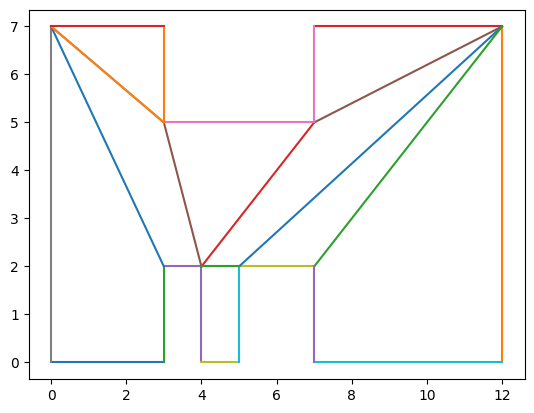

In [ ]:
simproom = np.array([[0,0], [3,0], [3,2], [4,2], [4,0], [5,0], [5,2], [7,2], [7,0], [12,0], [12,7], [7,7], [7,5], [3,5], [3, 7], [0,7]], dtype=float)
trigs, edges, vertices, edgepoly = seidel_trig(simproom)
partitionededges = hertel_mehlhorn(simproom)
edgeall = alledges(partitionededges, edgepoly)
for edge in edgeall:
  plt.plot([vertices[edge[0],0], vertices[edge[1],0]], [vertices[edge[0],1], vertices[edge[1],1]])

It does! Yay!

# Algorithm $A^{*}$

- We will use the ```shapely``` package here to make things a little easier.
- The code below includes functions for converting a convex partition into a graph that can be used in path-finding.
- The implementation and testing of the Algorithm $A^*$ is the programming assignment


In [ ]:
# Triangulation is carried out in the convex hull and not within the polygon.
# We will select triangles within the polygon
def triangulate_within(polygon):
    return [triangle for triangle in triangulate(polygon) if triangle.within(polygon)]

def getgraph(points): # We are not doing any type-checking, which is not good!
  polygon = Polygon(points)
  # trig = triangulate(roompoly)
  trig = triangulate_within(polygon)
  print(trig[0])
  vertices = []
  edges = []
  for ply in trig:
    neighs = ply.intersection(trig)
    cp1 = ply.centroid
    vertices.append(cp1)
    ln = len(neighs)
    for ind in range(ln):
      neig = neighs[ind]
      # Two triangles are neighbours only when their intersection is a LineString
      if type(neig) == LineString:
        cp2 = trig[ind].centroid
        edges.append(LineString([cp1, cp2])) # We are adding all edges twice so we will have to eliminate them at the end
  # Eliminate the duplicates now
  edgeiter = edges.copy()
  for edge in edgeiter:
    if len(np.where(edge.equals(edges)==True)[0]) > 1:
      edges.remove(edge)
  return vertices, edges

def plotgraph(vertices, edges):
  x, y = [], []
  for v in vertices:
    x.append(v.x)
    y.append(v.y)
  plt.scatter(np.array(x), np.array(y))
  for e in edges:
    plt.plot([e.coords[0][0], e.coords[1][0]], [e.coords[0][1], e.coords[1][1]], 'm')

## **Testing code** ✅

POLYGON ((0 7, 0 0, 3 2, 0 7))


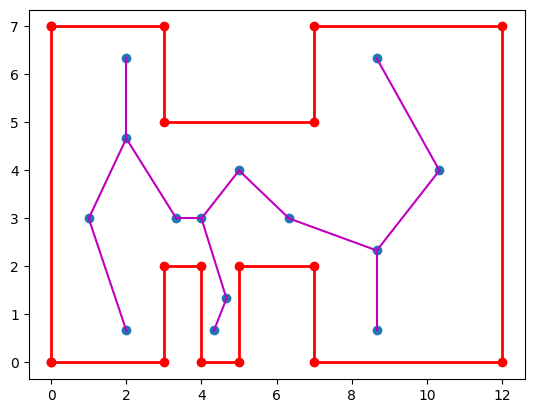

In [ ]:
v, e = getgraph(simproom)
plotpoly(simproom, False)
plotgraph(v, e)

# Programming Assignment #5

## **Fall 2023/24 Semester**

Implement both Dijkstra and $A^*$ algorithms. Using the same input compare their computational efficiencies.

1. Implement both of the algorithms
2. Give both the same problem domains, converted to a graph with appropriate processing
3. Run the algorithms multiple times for randomly selected start-end nodes and log the running time (e.g. 10 time for each randomly selected pair for 10 random selections)
4. Plot the average running time and the dispersion of the running time.
5. Comment on which algorithm works faster and why.

**GRADING:**
1. Algorithm implementation (40%):
  - Dijkstra algorithm is correctly implemented (20%)
  - $A^*$ algorithm is correctly implemented (20%)
2. Problem domain conversion (20%):
  - The input problem domain is converted to a graph with appropriate processing (20%)
3. Algorithm comparison (30%):
  - The algorithms are run multiple times for randomly selected start-end nodes (10%)
  - The running time is correctly logged (10%)
  - The average running time is plotted (5%)
  - The dispersion of the running time is plotted (5%)
4. Analysis (10%):
  - The analysis includes a comment on which algorithm works faster (5%)
  - The analysis includes a reason why the algorithm works faster (5%)

**Notes:**
1. You are free to use chatGPT for help. However, you should not use code generated by chatGPT directly and you should mention which part of the code is chatGPT in the comments. Your code will be checked for verbatim copying from chatGPT.
2. You are not allowed to use external modules/libraries in your implementations except those already in the notebook, but you can use them for testing your code.
3. You will upload your submission as a Python notebook to ODTUClass.

(c) Huseyin Hacihabiboglu, 2022-2024